# Iterations

решение уравнений методом последовательных итераций.

Постановка задачи:
Известно решение (M-model) для некоторой эпохи, сделан расчет содержания водорода на новую эпоху,
надо найти решение для новой эпохи, в предположении что решение изменилось не сильно.

In [1]:
import math
import numpy as np
import pandas as pd

%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
import NotebookLoader
import Physics as ph
import SSM18 as s

importing Jupyter notebook from Physics.ipynb
Physics version 1.14 13.07.2020
importing Jupyter notebook from SSM18.ipynb
SSM18 version 1.9 13.07.2020


In [3]:
pi = math.pi
Z = s.Z

In [4]:
def load_model(epoch):
    filename = 'Mass/3epoch%.02d.csv' % epoch
    return pd.read_csv(filename)

In [47]:
# Загружаем известное решение (M-model)
epoch = 0
df = load_model(epoch)
dimM = len(df.index)
df

,Unnamed: 0,Mass,Radius,Temperature,Density,Luminosity,Hydrogen,Opacity,Convection,Pressure,Velocity
0,0,0.000000e+00,0.000000e+00,1.451000e+07,90.073858,0.000000e+00,0.732,1.445415,1.0,1.794120e+17,1.208753e-10
1,1,1.990588e+30,1.744864e+09,1.439966e+07,89.041127,3.337100e+31,0.732,1.461410,0.0,1.760063e+17,1.149243e-10
2,2,3.981176e+30,2.201408e+09,1.433513e+07,88.430509,6.557975e+31,0.732,1.470834,0.0,1.740159e+17,1.115997e-10
3,3,5.971765e+30,2.522902e+09,1.428116e+07,87.917179,9.694220e+31,0.732,1.478767,0.0,1.723544e+17,1.089033e-10
4,4,7.962353e+30,2.779701e+09,1.423310e+07,87.458197,1.275919e+32,0.732,1.485871,0.0,1.708776e+17,1.065640e-10
...,...,...,...,...,...,...,...,...,...,...,...
996,996,1.982626e+33,4.139110e+10,9.072824e+05,0.203440,3.562824e+33,0.732,1.486150,0.0,2.533749e+13,1.087433e-21
997,997,1.984616e+33,4.188541e+10,8.016714e+05,0.166783,3.562824e+33,0.732,1.191579,0.0,1.835411e+13,2.401102e-22
998,998,1.986607e+33,4.249698e+10,6.818832e+05,0.125189,3.562824e+33,0.732,0.907523,0.0,1.171825e+13,3.241820e-23
999,999,1.988598e+33,4.336443e+10,5.328578e+05,0.075302,3.562824e+33,0.732,0.639191,0.0,5.508131e+12,1.428180e-24


In [48]:
m = df.Mass.values
r = df.Radius.values
t = df.Temperature.values
d = df.Density.values
l = df.Luminosity.values
x = df.Hydrogen.values
k = df.Opacity.values
c = df.Convection.values
p = df.Pressure.values
v = df.Velocity.values

In [49]:
# d1 = d.copy()
# t1 = t.copy()
# x1 = x.copy()
# # Вычисляем величины r,l,p,k,c,v из x,m,d,t
# r[0] = 0.
# l[0] = 0.
# for i in range(1, dimM):
#     r[i] = pow(pow(r[i-1], 3) + 3*(m[i] - m[i-1])/4/pi/d1[i-1], 1/3) 
#     l[i] = l[i-1] + (m[i] - m[i-1])*ph.Etot(0.5*(d1[i]+d1[i-1]), 0.5*(t1[i]+t1[i-1]), x1[i], 1 - Z - x1[i], Z)
# for i in range(dimM):
#     X = x1[i]
#     Y = 1 - Z -X
#     p[i] = ph.Pressure(d1[i], t1[i], X, Y, Z)
#     k[i] = ph.Opacity(d1[i], t1[i], X, Y, Z)
#     v[i] = 4*ph.m_prot*ph.Etot(d1[i], t1[i], X, Y, Z)/X/ph.dEpp*ph.year

In [50]:
# a = np.zeros(dimM) # градиент давления

# b = np.zeros(dimM) # градиент температуры
# br = np.zeros(dimM) # градиент температуры при радиации
# bc = np.zeros(dimM) # градиент температуры при конвекции
ea = np.zeros(dimM) # несоответствие градиента давления
eb = np.zeros(dimM) # несоответствие градиента температуры 

In [51]:
def Error(df):
    """
    Вычисляем интегральную ошибку решения.
    
    Ошибка складывается из ошибок выполнения условий гидростатики и энергобаланса в каждой точке сетки кроме первой 
    и последней.
    
    :param df pandas.dataFrame - M-model
    :return error
    """
    m = df.Mass.values
    r = df.Radius.values
    t = df.Temperature.values
    d = df.Density.values
    l = df.Luminosity.values
    x = df.Hydrogen.values
    k = df.Opacity.values
    c = df.Convection.values
    p = df.Pressure.values
    v = df.Velocity.values
    dimM = len(df)
    sa = 0
    sb = 0
    for i in range(1, dimM - 1):
        X = x[i]
        Y = 1 - Z - X
        mu = ph.MU(X, Y, Z)
        g = ph.G*m[i]/pow(r[i], 2)
        a = -g*d[i]
        da = (p[i+1] - p[i])/2/(r[i+1] - r[i]) + (p[i] - p[i-1])/2/(r[i] - r[i-1])
        br = -3/16*k[i]*d[i]*l[i]/ph.sigma/pow(t[i], 3)/4/pi/pow(r[i], 2)
        bc = -0.4*mu/ph.kB*ph.m_prot*g
        if abs(br) < abs(bc):
            b = br
        else:
            b = bc
        db = (t[i+1] - t[i])/2/(r[i+1] - r[i]) + (t[i] - t[i-1])/2/(r[i] - r[i-1])
        ea[i] = (da - a)/6760886
        eb[i] = (db - b)/0.000324
        sa += pow(ea[i], 2)
        sb += pow(eb[i], 2)
#     print(sa, sb)
    return (sa*3 + sb)/0.09726621893099568

In [39]:
df = df0.copy()

In [52]:
Error(df)

0.42324170657367943

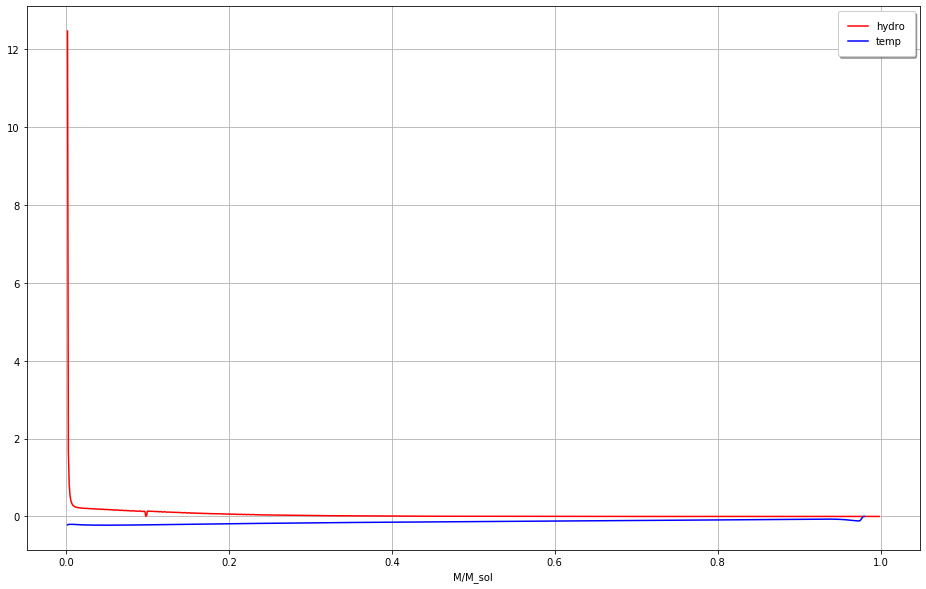

In [58]:
plt.figure(figsize=(16, 10))
ax = plt.axes()
# plt.plot(r1, c, color='black', label='Convection')
plt.plot(m[2:-2]/s.M, ea[2:-2], color='red', label='hydro')
plt.plot(m[2:-20]/s.M, eb[2:-20], color='blue', label='temp')
# plt.xlim(-0.1,0.1)
# plt.ylim(-0.1, 0.1)
plt.xlabel('M/M_sol')
plt.ylabel('')
# plt.title('Error %.2f' % etot)
ax.grid(b=True, which='both')
ax.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1);

In [59]:
eb, ea


(array([ 0.        , -0.23437523, -0.21668993, ...,  0.0924628 ,
        -0.2017459 ,  0.        ]),
 array([ 0.00000000e+00,  7.94362024e+00,  1.24615318e+01, ...,
        -2.62192173e-04, -3.90619174e-04,  0.00000000e+00]))

In [54]:
NG = 60 
err = np.zeros(NG + 1)
df0 = df.copy() # сохраняем исходное решение для начальной эпохи.
x0 = df0.Hydrogen.values.copy()
x = x0*np.exp(-1e9*v)
l[0] = 0.
for i in range(dimM):
    l[i] = l[i-1] + (m[i] - m[i-1])*ph.Etot(0.5*(d[i] + d[i-1]), 0.5*(t[i] + t[i-1]), x[i], 1 - Z - x[i], Z)
# Теперь в df - начальное приближение для новой эпохи.

In [55]:
count = 0
err[count] = Error(df)
err[count]

2403.1788799521946

In [57]:
%%time
"""
Цикл итераций. NG - число итераций, count - переменная цикла.
"""

count = 0
k0 = 0.0001

while count < 1: #NG:
    # Варьируем решения на величины, пропорциональные градиент, получая следующую итераци.
    for i in range(1, dimM - 1):
        r[i] = r[i]*(1 - k0*ea[i])
        t[i] = t[i]*(1 - k0*eb[i])
    d[0] = 3*m[1]/4/ph.pi/pow(r[1], 3)
#     t[0] = ????
    l[0] = 0.
    for i in range(1, dimM - 1):
        d[i] = 1/4/ph.pi/pow(r[i], 2)*(m[i+1] - m[i-1])/(r[i+1]-r[i-1])
        l[i] = l[i-1] + (m[i] - m[i-1])*ph.Etot(0.5*(d[i] + d[i-1]), 0.5*(t[i] + t[i-1]), x[i], 1 - Z - x[i], Z)
    for i in range(dimM - 1):
        k[i] = ph.Opacity(d[i], t[i], x[i], 1 - Z - x[i], Z)
        p[i] = ph.Pressure(d[i], t[i], x[i], 1 - Z - x[i], Z)
#         print('i=%d r=%.2f r1=%.2f t=%.1f t1=%.1f' % (i, r[i], r1[i], t[i], t1[i]))
    err0 = err[count]
    count += 1
    err1 = Error(df)
    
    err[count] = err1
    print('count=%d Error=%.2f Ratio=%.3f' % (count, err[count], 100*err0/err1 - 100.))
#     if err0 <= err1:
#         break

count=1 Error=7209.24 Ratio=-66.665
Wall time: 75 ms


In [145]:
df1 = pd.DataFrame({'Mass': m, 'Radius': r, 'Temperature': t1, 'Density': d1, 
          'Luminosity': l, 'Hydrogen': x1, 'Opacity': k, 'Pressure': p, 'Velocity': v})
df1

,Mass,Radius,Temperature,Density,Luminosity,Hydrogen,Opacity,Pressure,Velocity
0,0.000000e+00,0.000000e+00,1.476102e+07,95.295625,0.000000e+00,0.648658,1.390872,1.809783e+17,1.257492e-10
1,1.990588e+30,1.708467e+09,1.463609e+07,94.237343,3.113680e+31,0.652529,1.411856,1.780057e+17,1.192188e-10
2,3.981176e+30,2.156555e+09,1.455812e+07,93.620852,6.103297e+31,0.654702,1.425568,1.762054e+17,1.154029e-10
3,5.971765e+30,2.471982e+09,1.449126e+07,93.102711,9.011494e+31,0.656470,1.437577,1.746720e+17,1.122645e-10
4,7.962353e+30,2.723875e+09,1.443079e+07,92.637631,1.185084e+32,0.658008,1.448599,1.732866e+17,1.095219e-10
...,...,...,...,...,...,...,...,...,...
996,1.982626e+33,4.110901e+10,9.075170e+05,0.204089,3.337344e+33,0.732000,2.761272,2.542492e+13,1.093885e-21
997,1.984616e+33,4.156326e+10,8.019864e+05,0.167307,3.337344e+33,0.732000,2.357034,1.841899e+13,2.418664e-22
998,1.986607e+33,4.210426e+10,6.822346e+05,0.125576,3.337344e+33,0.732000,1.881852,1.176054e+13,3.269625e-23
999,1.988598e+33,4.280412e+10,5.331910e+05,0.075531,3.337344e+33,0.732000,1.297275,5.528353e+12,1.442041e-24


In [146]:
epoch = 1
_ = df1.to_csv(line_terminator='\n')
filename = "Mass/3epoch%.02d.csv" % epoch
print(filename)
csv_file = open(filename, "wt")
n = csv_file.write(_)
csv_file.close()

Mass/3epoch01.csv


In [147]:
epoch = 0
df = load_model(epoch)
d = df['Density'].values
t = df['Temperature'].values
d

array([9.00738577e+01, 8.90411272e+01, 8.84305086e+01, ...,
       1.25189351e-01, 7.53021785e-02, 2.09797553e-05])

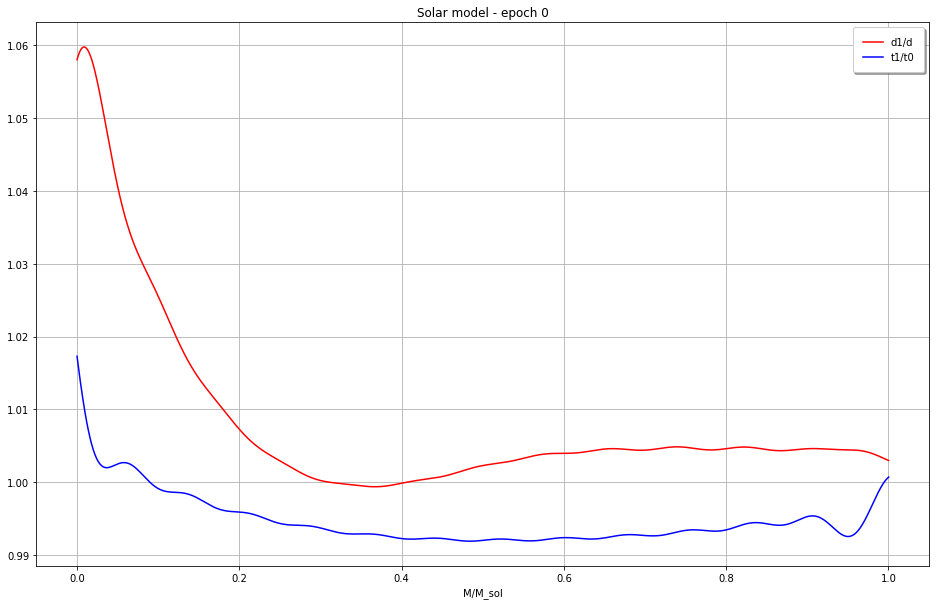

In [148]:
m1 = m/s.M
plt.figure(figsize=(16, 10))
ax = plt.axes()
# plt.plot(r1, c, color='black', label='Convection')
plt.plot(m1, d1/d, color='red', label='d1/d')
plt.plot(m1, t1/t, color='blue', label='t1/t0')
# plt.xlim(-0.1,0.1)
# plt.ylim(-0.1, 0.1)
plt.xlabel('M/M_sol')
plt.ylabel('')
plt.title('Solar model - epoch %d' % epoch)
ax.grid(b=True, which='both')
ax.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1);

In [149]:
ea = np.zeros(dimM)
eb = np.zeros(dimM)
for i in range(1, dimM-1):
    ea[i] = 3*pow((da[i] - a[i])/6760886, 2)
    eb[i] = pow((db[i] - b[i])/0.000324, 2)
sa = ea.sum()
sb = eb.sum()
etot = (sa + sb)/0.09726621893099568

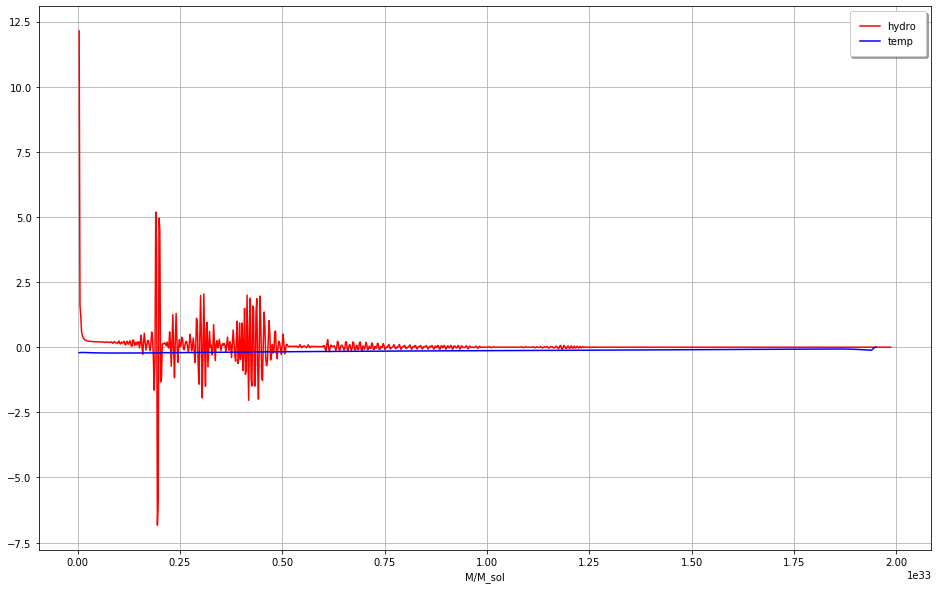

In [37]:
plt.figure(figsize=(16, 10))
ax = plt.axes()
# plt.plot(r1, c, color='black', label='Convection')
plt.plot(m[2:-2], ea[2:-2], color='red', label='hydro')
plt.plot(m[2:-20], eb[2:-20], color='blue', label='temp')
# plt.xlim(-0.1,0.1)
# plt.ylim(-0.1, 0.1)
plt.xlabel('M/M_sol')
plt.ylabel('')
# plt.title('Error %.2f' % etot)
ax.grid(b=True, which='both')
ax.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1);